# Time Series Forecasting Project

In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import statsmodels.api as sm
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import *
from prophet import Prophet
from sklearn.multioutput import MultiOutputRegressor, RegressorChain
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf

In [85]:
url = 'https://raw.githubusercontent.com/4GeeksAcademy/alternative-time-series-project/main/sales.csv'
df = pd.read_csv(url)
df

,date,sales
0,2022-09-03 17:10:08.079328,55.292157
1,2022-09-04 17:10:08.079328,53.803211
2,2022-09-05 17:10:08.079328,58.141693
3,2022-09-06 17:10:08.079328,64.530899
4,2022-09-07 17:10:08.079328,66.013633
...,...,...
361,2023-08-30 17:10:08.079328,989.600354
362,2023-08-31 17:10:08.079328,994.987326
363,2023-09-01 17:10:08.079328,995.814415
364,2023-09-02 17:10:08.079328,997.350214


In [86]:
print(f'Shape: {df.shape}')
print(f'''Nan Values: 
      {df.isna().sum()}''')
df.info()

Shape: (366, 2)
Nan Values: 
      date     0
sales    0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    366 non-null    object 
 1   sales   366 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.8+ KB


In [87]:
print(f'Number of duplicated rows: {df.duplicated().sum()}')

Number of duplicated rows: 0


## Step 2: Construct and analyze the time serie

Construct the valid data structure for the time serie, graph it, 

In [88]:
df.date = df.date.str.split(' ').str[0]     # Me quedo solo con las fechas ya que la hora es intrascendente
df.date = pd.to_datetime(df.date)           # Paso los valores a datetime values
df = df.set_index('date')                   # Paso la serie de fecha a index
df

,sales
date,
2022-09-03,55.292157
2022-09-04,53.803211
2022-09-05,58.141693
2022-09-06,64.530899
2022-09-07,66.013633
...,...
2023-08-30,989.600354
2023-08-31,994.987326
2023-09-01,995.814415


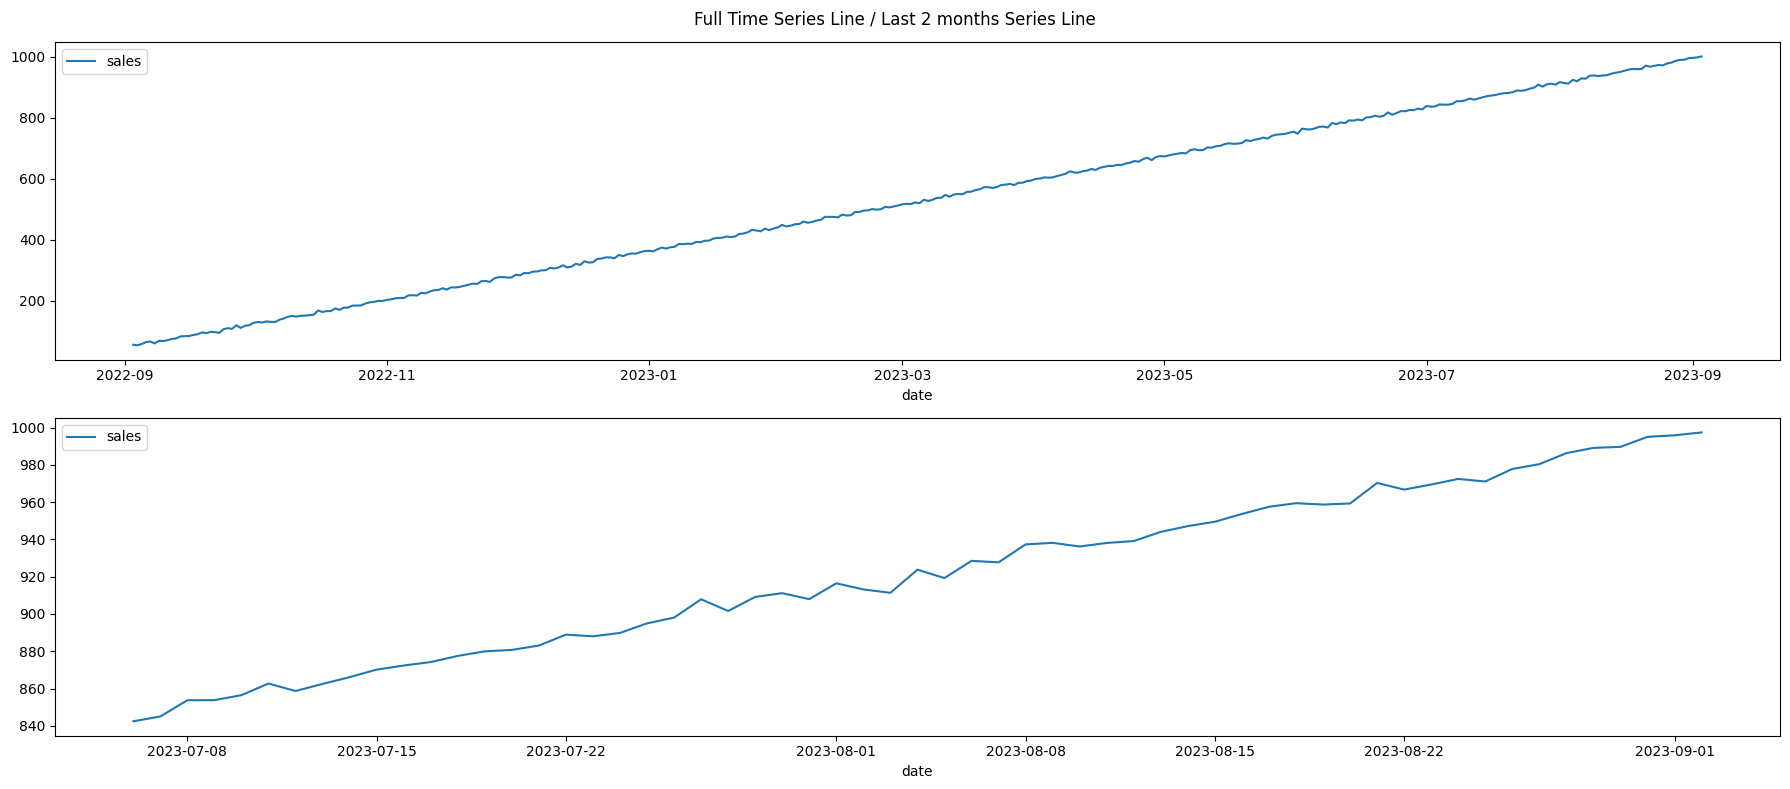

In [93]:
fig, axis = plt.subplots(2,1,figsize=(18,8))
plt.suptitle('Full Time Series Line / Last 2 months Series Line')
sns.lineplot(data = df,ax=axis[0])
sns.lineplot(data = df[-60:-1],ax=axis[1])
plt.tight_layout()
plt.show()

### Answer the following questions:
*   Which is the tensor of the time serie?

                The tensor for this simple serie, seems to be a vector (range 1) expresed by the values included in column 'sales'.


In [90]:
# Para responder la proxima pregunta debo descomponer la serie, lo hare de manera mensual
decomposition = seasonal_decompose(df, period = 12)
decomposition

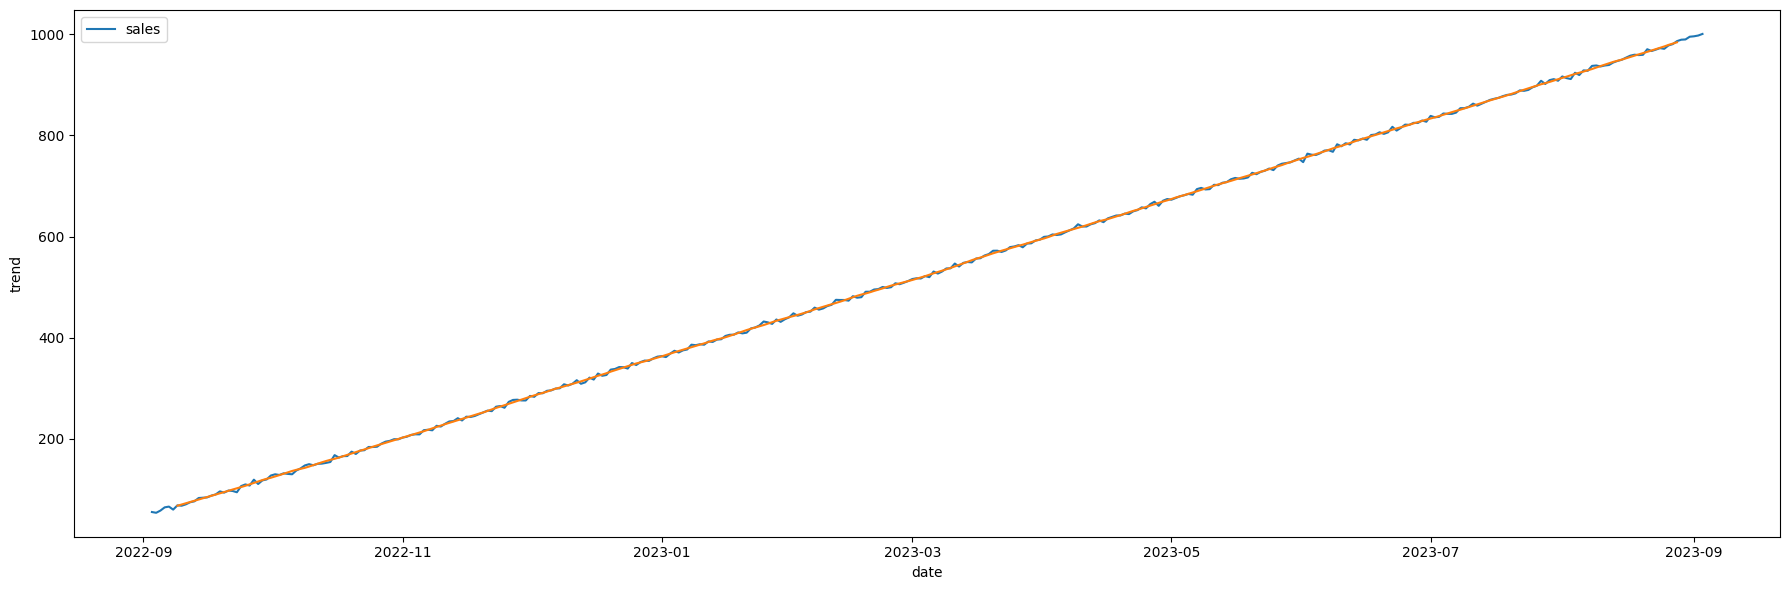

In [91]:
trend = decomposition.trend
fig, axis = plt.subplots(figsize=(18,6))
sns.lineplot(data = df)
sns.lineplot(data = trend)
plt.tight_layout()
plt.show()

*   Which is the trend?

        The big picture is showing us a pattern of constant increase in all data series

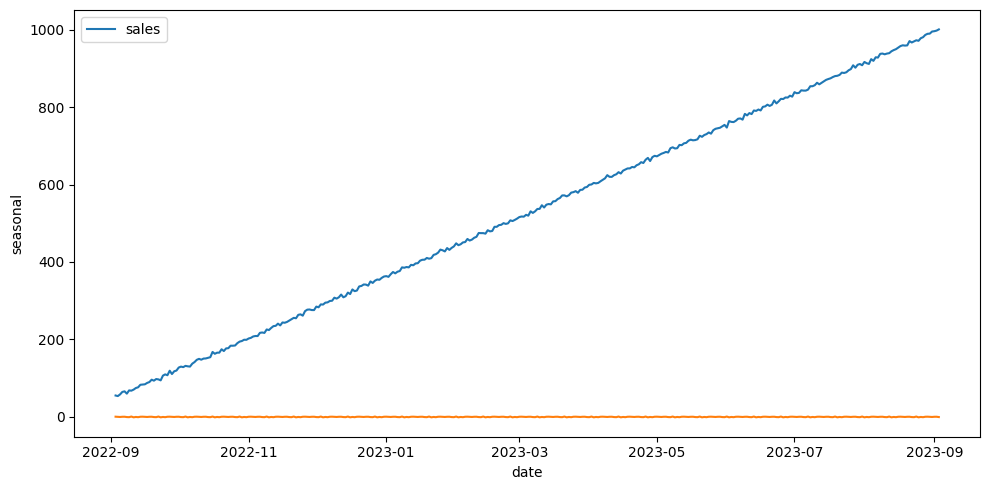

In [94]:
seasonal = decomposition.seasonal
fig, axis = plt.subplots(figsize = (10, 5))
sns.lineplot(data = df)
sns.lineplot(data = seasonal)
plt.tight_layout()
plt.show()

In [96]:
def test_stationarity(timeseries):
    print("Dickey-Fuller Test Results")
    dftest = adfuller(timeseries, autolag = "AIC")
    dfoutput = pd.Series(dftest[0:4], index = ["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
    for key,value in dftest[4].items():
        dfoutput["Critical Value (%s)"%key] = value
    return dfoutput

test_stationarity(df)

Dickey-Fuller Test Results


Test Statistic                   0.545414
p-value                          0.986190
#Lags Used                      13.000000
Number of Observations Used    352.000000
Critical Value (1%)             -3.449065
Critical Value (5%)             -2.869786
Critical Value (10%)            -2.571163
dtype: float64

*   Is it stationary?

        This numbers suggest that the time series is not stationary. We should say that the test is failing to reject the null-hypothesis of non-stationary

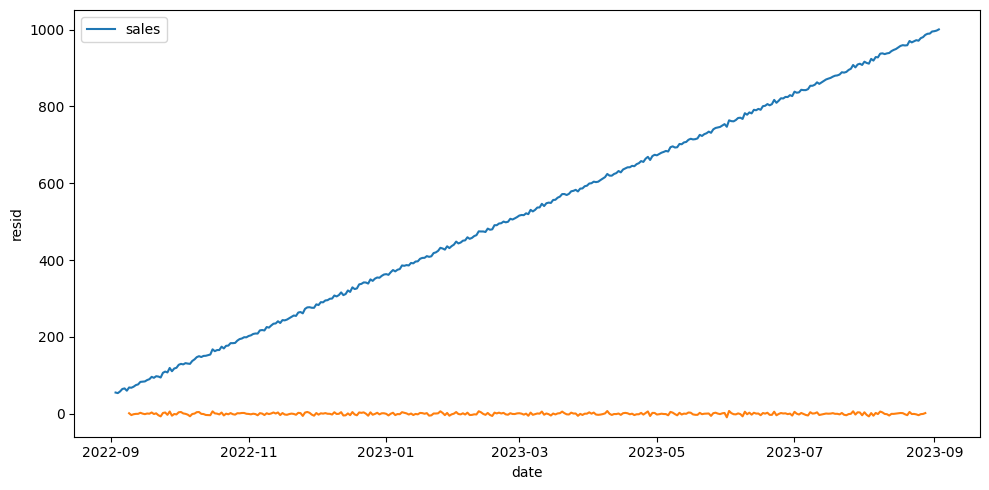

In [97]:
residual = decomposition.resid
fig, axis = plt.subplots(figsize = (10, 5))
sns.lineplot(data = df)
sns.lineplot(data = residual)
plt.tight_layout()
plt.show()

*   Is there variability or noise?

        We can observe the noise is present but very low amplitude, practically insignificant. Fluctuations around zero suggest that there isn't much explanined variability after accounting for the trend, so residuals mostly capture minor random variables.

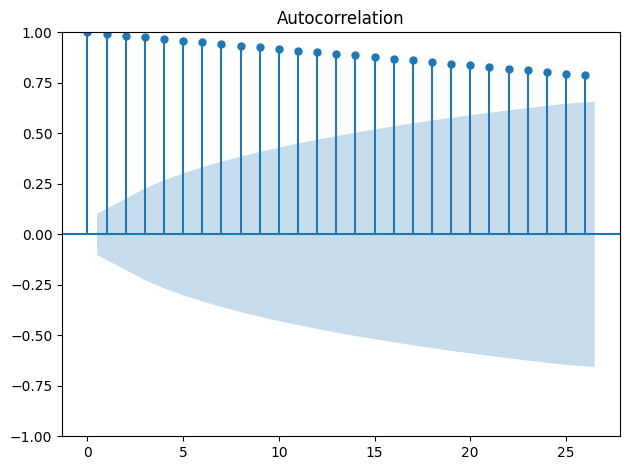

In [98]:
# Grafico de Autocorrelacion para medir como los valores se encuentran relacionados con sus rezagos a traves del tiempo
plot_acf(df)
plt.tight_layout()
plt.show()

Key observations from the ACF:
- High autocorrelation at all tags: values close to 1 suggests that the time series exhibit strong autocorrelation over time. This means past values are higly predictive for future values, and strong temporal dependence in the data
- Non-stationary: the autocorrelation is persistantly high and doesn't drop off quickly, simphtom of a typical non-stationary time series. In a stationary series, autocorrelation would drop towards 0 relatively quikcly as the lag increases .

## Step 3: Train an ARIMA
Use the training data to find the best parameterization of your ARIMA model.